<a href="https://colab.research.google.com/github/vt-ai-ml-club/repo/blob/master/Fall2020/MultilayerPerceptron/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                                        # vector, matrix manipulation
import pandas as pd                                       # handling data frames
from sklearn.model_selection import train_test_split      # splitting our data into training/testing
from sklearn.neural_network import MLPClassifier          # Multilayer Perceptron for classification

We are going to work with admission data from a population of India graduate students.

https://www.kaggle.com/mohansacharya/graduate-admissions

In [ ]:
# Send an http request and read the request response as a csv
url = "https://raw.githubusercontent.com/ajh1143/GraduateAdmissionsDataScienceAnalysis/master/Dataset/Admission_Predict.csv"
admission_data = pd.read_csv(url)
admission_data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [ ]:
# Drop a useless column and create a new variable
data = admission_data.copy()
data.drop('Serial No.', axis=1, inplace=True)
data['Admission'] = data['Chance of Admit '].apply(lambda p: 0 if p < 0.5 else 1)
data.drop('Chance of Admit ', axis=1, inplace=True)
data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission
0,337,118,4,4.5,4.5,9.65,1,1
1,324,107,4,4.0,4.5,8.87,1,1
2,316,104,3,3.0,3.5,8.00,1,1
3,322,110,3,3.5,2.5,8.67,1,1
4,314,103,2,2.0,3.0,8.21,0,1


Exploratory Data Analysis

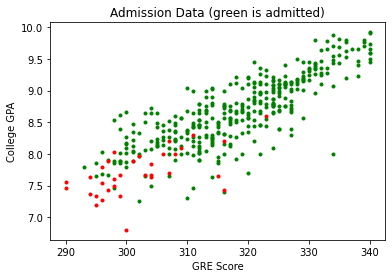

In [ ]:
import matplotlib.pyplot as plt

def plot_data(dataset):
  # partition the data based off if they were admitted or not
  admitted = dataset.loc[dataset['Admission'] == 1]
  not_admitted = dataset.loc[dataset['Admission'] == 0]

  plt.scatter(admitted['GRE Score'], admitted['CGPA'], color='g', marker='.')
  plt.scatter(not_admitted['GRE Score'], not_admitted['CGPA'], color='r', marker='.')

  plt.title('Admission Data (green is admitted)')
  plt.xlabel('GRE Score')
  plt.ylabel('College GPA')

plot_data(data)

In [ ]:
# Define our input variables and our output variable
x = data.drop('Admission', axis=1)      
y = data['Admission']

# Create our train/test split (We'll traing with 15% of the dataset)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0)
print("# of training data points %d" % (x_train.size))
print("# of testing data points: %d" % (x_test.size))

# of training data points 2380
# of testing data points: 420


In [ ]:
# Create our model with 3 hidden layers
mlp = MLPClassifier(hidden_layer_sizes=(2,4,2), activation='logistic', max_iter=1000)

# Train our model using backpropagation (we'll cover this next time)
mlp.fit(x_train, y_train)

# Let's see how well our MLP does
out_of_sample_accuracy = mlp.score(x_test, y_test)
print('Our MLP has an %.2f percent accuracy' % (out_of_sample_accuracy * 100))

Our MLP has an 91.67 percent accuracy


In [ ]:
# Let's look at data for someone who had an admission chance < 0.5
print(data[data['Admission'] == 0].iloc[0])

GRE = 323
TOEFL = 108
UNI_RATING = 3
SOP = 3.5
LOR = 3.0
CGPA = 8.60
RESEARCH = 0
example = np.array([[GRE, TOEFL, UNI_RATING, SOP, LOR, CGPA, RESEARCH]])

prediction = mlp.predict(example)

print('---')
print('Were they admitted? {}'.format('YES' if prediction == 1 else 'NO'))

GRE Score            323.0
TOEFL Score          108.0
University Rating      3.0
SOP                    3.5
LOR                    3.0
CGPA                   8.6
Research               0.0
Admission              0.0
Name: 9, dtype: float64
---
Were they admitted? YES


## Why could this be?

We need good data to have a good model.

In [ ]:
print('# of \'no admissions\' %d' % (len(data[data.Admission == 0])))
print('# of \'admissions\' %d' % (len(data[data.Admission == 1])))

# of 'no admissions' 33
# of 'admissions' 367


**[Resampling](https://en.wikipedia.org/wiki/Resampling_(statistics))** is a tool we can use to handle data with imbalanced classes.


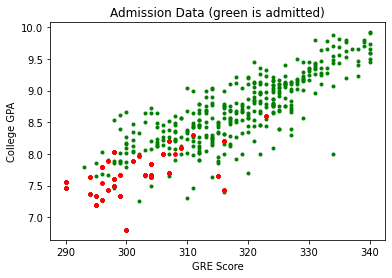

In [ ]:
from sklearn.utils import resample                                # generate more sample data

# Separate majority and minority classes
data_majority = data[data.Admission==1]
data_minority = data[data.Admission==0]
 
 
# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,                    # sample with replacement
                                 n_samples=len(data_majority),    # to match majority class
                                 random_state=123)                # reproducible results
 

# Combine majority class with upsampled minority class
new_data = pd.concat([data_majority, data_minority_upsampled])

plot_data(new_data)

### Undersample
We could also undersample (reduce number of data points for the majority class)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


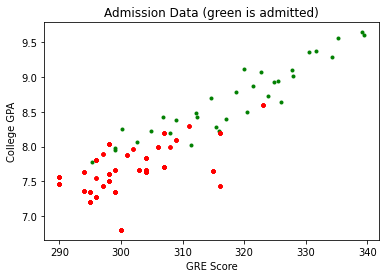

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={1:len(data_minority)})

new_x, new_y = cc.fit_sample(x, y)
new_data2 = pd.DataFrame(new_x, columns=x.columns)
new_data2['Admission'] = new_y
plot_data(new_data2)

### Run it back

In [ ]:
# Define our predictor variables and our response variable in our new dataset
x = new_data.drop('Admission', axis=1)      
y = new_data['Admission']


# Create our train/test split with the new data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0)


# Create a MLP using a sigmoid and relu activation function
mlp_log = MLPClassifier(hidden_layer_sizes=(2,4,2), activation='logistic', max_iter=1000, random_state=0)
mlp_relu = MLPClassifier(hidden_layer_sizes=(2,4,2), activation='relu', max_iter=1000, random_state=0)

mlp_log.fit(x_train, y_train)
mlp_relu.fit(x_train, y_train)


# Let's see how well our MLP does
out_of_sample_accuracy_log = mlp_log.score(x_test, y_test)
out_of_sample_accuracy_relu = mlp_relu.score(x_test, y_test)
print('Our MLP w/ sigmoid has an %.2f percent accuracy' % (out_of_sample_accuracy_log * 100))
print('Our MLP w/ relu has an %.2f percent accuracy' % (out_of_sample_accuracy_relu * 100))


prediction_log = mlp_log.predict(example)
prediction_relu = mlp_relu.predict(example)
print('---')
print('MLP w/ sigmoid: Were they admitted? {}'.format('YES' if prediction_log == 1 else 'NO'))
print('MLP w/ relu   : Were they admitted? {}'.format('YES' if prediction_relu == 1 else 'NO'))

Our MLP w/ sigmoid has an 45.05 percent accuracy
Our MLP w/ relu has an 75.68 percent accuracy
---
MLP w/ sigmoid: Were they admitted? YES
MLP w/ relu   : Were they admitted? NO
